# DeepShap interpretation of  LSTM model

Here I use DeepShap (Lundberg et al) to interprete a LSTM model that I developed for predicting peptide acetylation from mass spectrometry data

### Load the data and LSTM model

In [2]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load preprocessed mass spectrometry data
spec = np.load('spectrum_vector_of_2000.npy')
label = np.load('label.npy')

In [4]:
spec[345][100:200]

array([0.        , 0.13579674, 0.04774293, 0.        , 0.        ,
       0.        , 0.0103139 , 0.        , 0.        , 0.        ,
       0.06427515, 0.        , 0.        , 0.        , 0.        ,
       0.01383264, 0.        , 0.01319529, 0.        , 0.20302723,
       0.30109102, 0.01262504, 0.        , 0.        , 0.01198609,
       0.        , 0.04839129, 0.        , 0.        , 0.16489451,
       0.1125042 , 0.        , 0.01692063, 0.14802835, 0.        ,
       0.0450373 , 0.21166902, 0.04326786, 0.        , 0.        ,
       0.        , 0.02489658, 0.01244917, 0.05132096, 0.        ,
       0.06908179, 0.        , 0.0709521 , 0.        , 0.        ,
       0.        , 0.02239946, 0.        , 0.        , 0.        ,
       0.1699603 , 0.        , 0.03210613, 0.        , 0.03309919,
       0.        , 0.        , 0.        , 0.01162331, 0.        ,
       0.        , 0.        , 0.        , 0.01257156, 0.        ,
       0.        , 0.02107225, 0.        , 0.2371246 , 0.     

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(spec, label, test_size=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [6]:
X_train.shape

(50757, 2000)

In [7]:
X_train[100][120:150]

array([0.027983  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03432841, 0.        , 0.09311442,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02621818, 0.04190456, 0.01640348, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02040392, 0.        , 0.        , 0.        , 0.20398195])

In [8]:
# reshape to match the LSTM model I use
X_train = X_train.reshape(50757,10,200)
X_val = X_val.reshape(6267,10,200)
X_test = X_test.reshape(5640,10,200)

In [9]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
dependencies = {
    'f1_m': f1_m,
    'precision_m': precision_m,
    'recall_m': recall_m
}


In [11]:
#Load one of the LSTM models I saved
from tensorflow.keras.models import load_model
#saved_model = load_model('uniLSTM_best_val_f1.h5', custom_objects=dependencies)
#saved_model = load_model('best_val_f1.h5', custom_objects=dependencies)
#saved_model = load_model('noPoolingLSTM_best_val_f1.h5', custom_objects=dependencies)
saved_model = load_model('normalPoolingLSTM_best_val_f1.h5', custom_objects=dependencies)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = saved_model.evaluate(X_test, y_test, verbose=0)
loss, accuracy, f1_score, precision, recall

(0.4551413104783559, 0.8803192, 0.70842993, 0.7167344, 0.7321012)

### Deep Shap to calculate Shap Values

In [11]:
!pip install shap

In [16]:
import shap

shap.initjs()

In [18]:
# select random 1000 samples to take an expectation over
#background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
background_sum = shap.sample(X_train, 1000)

In [19]:
background_sum.shape

(1000, 10, 200)

In [20]:
# use random 1000 train sample as background to integrate over
explainer = shap.DeepExplainer(saved_model, background_sum)

Using TensorFlow backend.


In [17]:
# pick random 1000 samples from test set to calculate shap values
randomID = np.random.choice(X_test.shape[0], 1000, replace=False)

In [18]:
np.save('lstm_randomID_4', randomID) # save the index of these random 1000 samples, so next time I can directly use 

In [19]:
randomID[2:5]

array([1315, 4368, 4009])

In [20]:
shap_values = explainer.shap_values(X_test[randomID])# calculate shap values for random 1000 test samples, took about 15min

In [21]:
shap_values[0].shape

(1000, 10, 200)

In [22]:
shap_values

[array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           5.59041904e-05,  6.31646854e-04,  1.45892253e-02],
         [-1.23032963e-04, -1.34257939e-03,  2.24794237e-04, ...,
           6.94566625e-04, -1.13831108e-04,  8.66833852e-04],
         [-2.07414922e-05,  1.22143392e-04,  3.87014642e-04, ...,
          -7.65838997e-04, -2.95556665e-04, -5.88975675e-04],
         ...,
         [-8.96666362e-06, -1.64855399e-04, -1.68246703e-05, ...,
           3.16229045e-07, -1.61630502e-09,  1.39595157e-08],
         [-1.87532433e-07,  2.45097445e-06,  2.71799682e-07, ...,
           6.37798718e-08,  0.00000000e+00,  0.00000000e+00],
         [ 8.90089544e-10,  1.18623936e-10,  5.67875279e-08, ...,
           2.35104795e-10, -3.80781072e-10,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -1.05258549e-03, -1.37799621e-04,  1.79328684e-03],
         [ 2.66478206e-03,  1.34180557e-04,  5.31978555e-04, ...,
          -4.14871473e-04, -5.92604547e-05, -1.15342256e-03],
         [-2.42675024e-04, -5.00043699e-04, -9.02592772e-04, ...,
           1.11589208e-03, -1.20074285e-04, -1.35327597e-03],
         ...,
         [-6.66683550e-05,  1.61538890e-05,  3.40553161e-05, ...,
           4.20839680e-06,  4.00277291e-06, -6.65890563e-07],
         [-1.67702114e-05,  2.26079624e-05, -2.89836013e-06, ...,
          -2.51778715e-06,  0.00000000e+00,  0.00000000e+00],
         [ 1.29709399e-07,  1.94970487e-07, -2.19078472e-06, ...,
          -1.97960224e-07, -9.74077614e-08,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -8.03822789e-03, -1.28555331e-03, -2.04338262e-04],
         [ 2.47681009e-03, -4.53228741e-02, -7.84629916e-03, ...,
          -3.13701772e-04, -1.93856202e-03, -3.35384051e-03],
         [-3.03574451e-04,  9.59397762e-04, -1.54236933e-03, ...,
          -2.00180133e-03,  7.64583886e-04, -1.85760041e-03],
         ...,
         [-5.78807753e-05, -8.80040455e-06, -2.27879279e-05, ...,
           2.06206982e-06,  1.50529673e-05,  8.70653617e-06],
         [-6.17115838e-05,  1.73879619e-05, -6.70719016e-06, ...,
          -8.28258538e-06,  0.00000000e+00,  0.00000000e+00],
         [ 8.94419794e-07,  9.78328700e-07, -7.87200393e-07, ...,
          -1.23541906e-06,  8.06639238e-07,  0.00000000e+00]],
 
        ...,
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           7.04430812e-04,  5.15327404e-04, -5.71477111e-04],
         [ 6.37264020e-03, -1.14944518e-03,  4.57791851e-04, ...,
           2.66772781e-03,  9.82372425e-04, -1.84149538e-03],
         [ 1.81892432e-04, -9.85940978e-04, -6.39757889e-04, ...,
          -6.32593103e-04,  5.47098773e-04, -1.33755135e-03],
         ...,
         [-6.77018859e-06, -1.33236549e-06, -3.10512944e-05, ...,
          -1.29743433e-05, -1.37608235e-05,  1.55413180e-05],
         [-3.28429988e-06,  1.43834943e-06,  1.72903724e-06, ...,
          -1.26503247e-05,  0.00000000e+00,  0.00000000e+00],
         [ 2.42155899e-06,  5.61176751e-07,  1.49388110e-07, ...,
          -1.67402014e-06,  7.55805205e-07,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.07587186e-04,  3.35919321e-05, -7.63905645e-04],
         [ 3.51992063e-04,  1.22398135e-04,  1.52443176e-06, ...,
          -3.02568486e-04,  8.01191440e-05, -2.63301773e-04],
         [-3.53423333e-05,  9.48122369e-05, -1.50671483e-04, ...,
          -3.36407512e-04,  5.86270965e-05,  6.15725852e-05],
         ...,
         [-2.72162798e-05,  7.29469764e-05,  3.05917228e-06, ...,
           3.41418072e-07,  2.12385907e-09, -1.05248022e-08],
         [-1.52511856e-06,  9.82148464e-06, -7.73684914e-08, ...,
           1.39528155e-07,  0.00000000e+00,  0.00000000e+00],
         [-2.08414939e-12,  2.11941768e-11, -9.62563260e-09, ...,
           1.01709805e-11,  2.17890761e-11,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,

In [23]:
#Save shap values so that I can use directly next time.
np.save('lstm_DeepExpain_sv1', shap_values) # this is the LSTM trained on 'normalPoolingLSTM_best_val_f1.h5'

### Plotting 

In [27]:
shap_values = np.load('lstm_DeepExpain_sv4.npy')
randomID = np.load('lstm_randomID_4.npy')

### (1) Summary plot

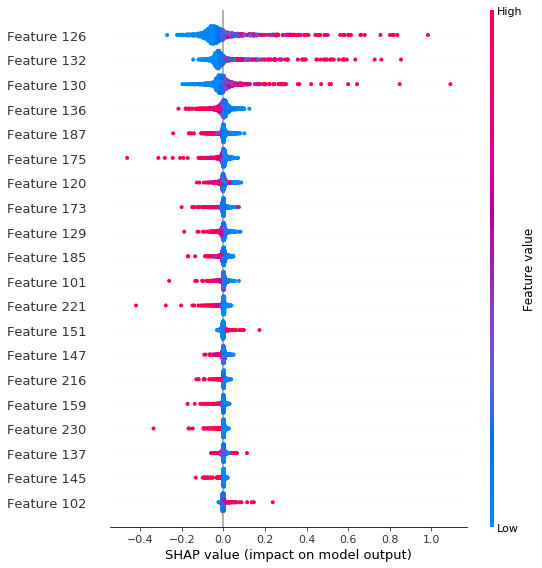

In [24]:
#shap.summary_plot(shap_values[0][400:450].reshape(50,2000), X_test[randomID[400:450]].reshape(50,2000))
shap.summary_plot(shap_values[0].reshape(1000,2000), X_test[randomID].reshape(1000,2000))

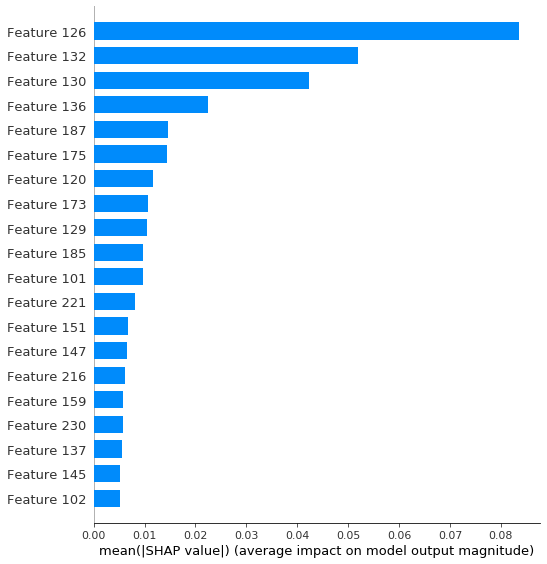

In [25]:
#shap.summary_plot(shap_values[0].reshape(48,2000), X_test[600:648].reshape(48,2000), plot_type="bar" )
shap.summary_plot(shap_values[0].reshape(1000,2000), X_test[randomID].reshape(1000,2000), plot_type="bar" )

### (2) Decision plot

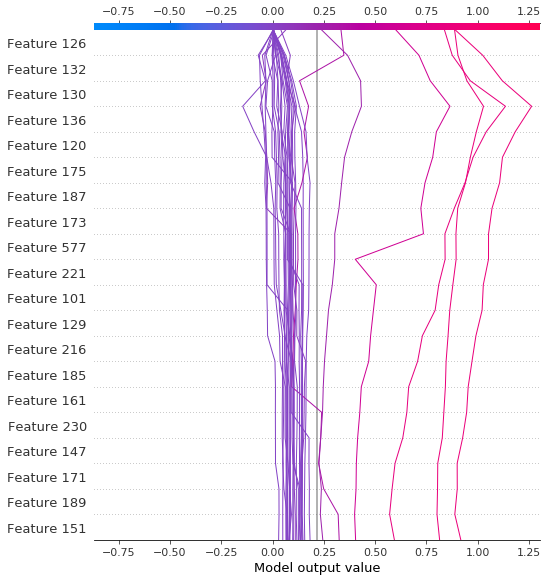

In [24]:
#shap.decision_plot(explainer.expected_value, shap_values[0][450:480].reshape(30,2000), feature_order='importance', feature_display_range=slice(-1000, -1200,-1))
shap.decision_plot(explainer.expected_value, shap_values[0][350:380].reshape(30,2000), feature_order='importance', feature_display_range=slice(-1, -21,-1))

### (3) Dependence plot

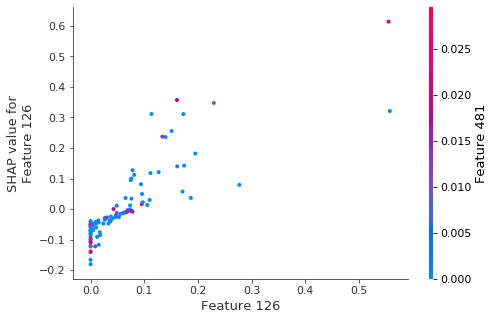

In [28]:
#shap.dependence_plot(126, shap_values[0].reshape(1000,2000),X_test[randomID].reshape(1000,2000))
shap.dependence_plot(126, shap_values[0][:100].reshape(100,2000),X_test[randomID[:100]].reshape(100,2000))
#shap.dependence_plot(1300, shap_values[0].reshape(1000,2000), X_test[randomID].reshape(1000,2000), interaction_index = None)

### (4) Force plot

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0][480].reshape(2000),X_test[randomID[480]].reshape(2000) )

In [94]:
shap_values[0][392].reshape(2000)[615]

0.0015739425936496711

In [30]:
shap.force_plot(explainer.expected_value[0], shap_values[0][470:490].reshape(20,2000),X_test[randomID[470:490]].reshape(20,2000) )

### (5) Self Plot: compare shap values over several repeats

In [32]:
# load shap values from 4 repeats
shap_values = np.load('lstm_DeepExpain_sv1.npy')
shap_values2 = np.load('lstm_DeepExpain_sv2.npy')
shap_values3 = np.load('lstm_DeepExpain_sv3.npy')
shap_values4 = np.load('lstm_DeepExpain_sv4.npy')

In [33]:
# convert from LSTM shape to shape of mass spec (2000 m/z)
SV = shap_values[0].reshape(1000,2000)
SV2 = shap_values2[0].reshape(1000,2000)
SV3 = shap_values3[0].reshape(1000,2000)
SV4 = shap_values4[0].reshape(1000,2000)

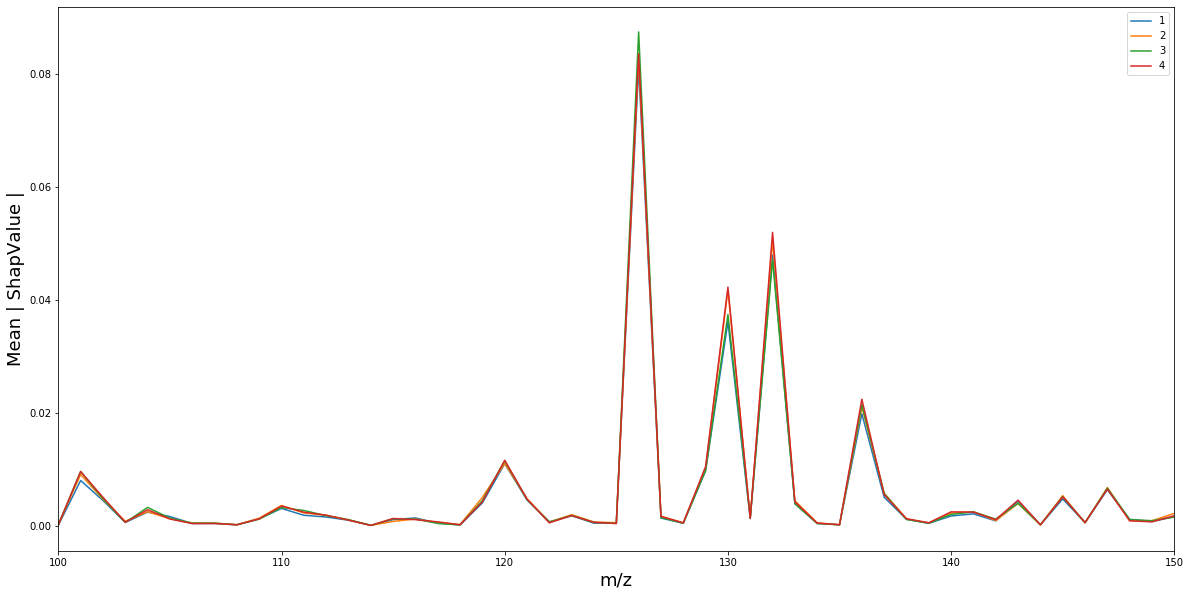

In [34]:
# plot average shap values over 1000 spectra

plt.figure(figsize=(20,10))
plt.plot (np.absolute(SV).mean(axis=0), label='1')
plt.plot (np.absolute(SV2).mean(axis=0), label = '2')
plt.plot (np.absolute(SV3).mean(axis=0), label = '3')
plt.plot (np.absolute(SV4).mean(axis=0), label = '4')

plt.xlim(100,150)
#plt.ylim(-0.1,1.1)
plt.xlabel('m/z', fontsize=18)
plt.ylabel('Mean | ShapValue |', fontsize=18)
plt.legend(loc="upper right")

### (6) Self plot: importance (1/ranking) over m/z

In [36]:
# get the importance rank of each m/z position

def get_rank(shapValue):    # shapValue contains shap_values. It is an array of shape(sample#, 2000)
    feature_rank = np.flip(np.absolute(shapValue).mean(axis=0).argsort())
    
    rank = np.zeros(1999)
    for i in range (1999):
        #print (i)
        rank[i] = np.where(feature_rank== i)[0][0]
        
    return rank

In [37]:
get_rank(shap_values2[0].reshape(1000,2000))

array([1999., 1847., 1846., ..., 1942., 1828., 1819.])

In [38]:
rank1 = get_rank(shap_values[0].reshape(1000,2000))
rank2 = get_rank(shap_values2[0].reshape(1000,2000))
rank3 = get_rank(shap_values3[0].reshape(1000,2000))
rank4 = get_rank(shap_values4[0].reshape(1000,2000))

In [39]:
a = np.array([rank1, rank2, rank3, rank4]) + 1  # plus 1 so that the ranking is from 1 to 2000, instead of 0 to 1999
a

array([[2000., 1886., 1885., ..., 1570., 1826., 1694.],
       [2000., 1848., 1847., ..., 1943., 1829., 1820.],
       [2000., 1856., 1857., ..., 1941., 1823., 1811.],
       [2000., 1882., 1887., ..., 1830., 1483., 1472.]])

In [40]:
avg = np.average(a, axis = 0)
std = np.std(a, axis = 0)

divide by zero encountered in true_divide


Text(0, 0.5, 'importance (1/ranking)')

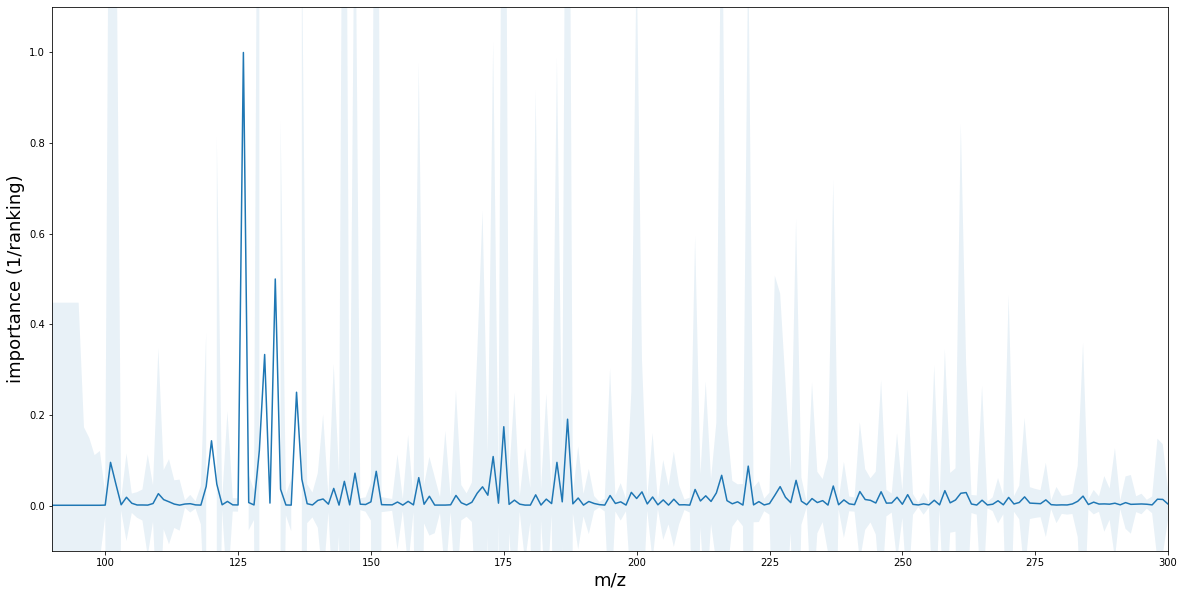

In [41]:
# plot the average ranking of each m/z position

plt.figure(figsize=(20,10))
plt.plot (1/avg)
plt.fill_between(range(1999),1/avg-1/std,1/avg+1/std,alpha=.1)
plt.xlim(90,300)
plt.ylim(-0.1,1.1)
plt.xlabel('m/z', fontsize=18)
plt.ylabel('importance (1/ranking)', fontsize=18)